In [46]:
import pyspark
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit, rand, row_number
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt

In [47]:
from pyspark.sql.types import DoubleType
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

In [48]:
mirai_devices = ['danmini_doorbell', 'ecobee_thermostat', 'philips_B120N10_baby_monitor',
                 'provision_PT_737E_security_camera', 'provision_PT_838_security_camera',
                 'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

benign = ['danmini_doorbell', 'ecobee_thermostat', 'ennio_doorbell', 'philips_B120N10_baby_monitor',
          'provision_PT_737E_security_camera', 'provision_PT_838_security_camera', 'samsung_SNH_1011_N_webcam',
          'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

mirai_attacks = ['ack',  # automatic scan for vulnerable devices
                 'scan',  # ack flood
                 'syn',  # syn flood
                 'udp',  # udp flood
                 'udpplain']  # optimized udp flood

In [49]:
first = True
mirai_data = None
for device in mirai_devices:
    for attack in mirai_attacks:
        if first:
            mirai_data = spark.read.option("inferSchema", True)\
                .option("header", True).csv(f'../data/n_balo_t/{device}/mirai_attacks/{attack}.csv')
            mirai_data = mirai_data.withColumn("label", lit(attack))
            first = False
        else:
            to_add = spark.read.option("inferSchema", True)\
                .option("header", True).csv(f'../data/n_balo_t/{device}/mirai_attacks/{attack}.csv')
            to_add = to_add.withColumn("label", lit(attack))
            mirai_data = mirai_data.union(to_add)
first = True
benign_data = None
for device in benign:
    if first:
        benign_data = spark.read.option("inferSchema", True)\
            .option("header", True).csv(f'../data/n_balo_t/{device}/benign_traffic.csv')
        first = False
    else:
        to_add = spark.read.option("inferSchema", True)\
            .option("header", True).csv(f'../data/n_balo_t/{device}/benign_traffic.csv')
        benign_data = benign_data.union(to_add)
benign_data = benign_data.withColumn('label', lit("benign"))

mirai_data = mirai_data.union(benign_data)

print(f'total data for prediciton modeling = {mirai_data.count()}')

total data for prediciton modeling = 4224334


In [50]:
cols = mirai_data.columns
new_cols = [str(i) for i in range(len(cols))]
mirai_data = mirai_data.toDF(*new_cols)
mirai_data = mirai_data.withColumnRenamed('115', 'label')

In [51]:
def pie(k, num):
    labels = [x[0] for x in k]

    sizes = [x[1] for x in k]

    percent = [100*(p/sum(sizes)) for p in sizes]

    colors = ['tab:blue', 'tab:green', 'tab:orange',
              'tab:red', 'tab:gray', 'tab:olive']

    patches, texts = plt.pie(sizes, colors=colors, startangle=90, radius=1.2)
    labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(labels, percent)]

    sort_legend = True
    if sort_legend:
        patches, labels, dummy = zip(*sorted(zip(patches, labels, sizes),
                                             key=lambda x: x[2],
                                             reverse=True))

    plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.),
               fontsize=8)

    plt.savefig('piechart.png', bbox_inches='tight')

    plt.title(f'Cluster Composition for K{num}')

    plt.show()


def reg_kmeans(data, min_k=2, max_k=5):
    feature_list = []
    for col in data.columns:
        if col == 'label':
            continue
        else:
            feature_list.append(col)

    # set up feature and labels as input and output
    asmblr = VectorAssembler(inputCols=feature_list, outputCol="features")

    assembled_data = asmblr.transform(data)

    scale = StandardScaler(inputCol='features', outputCol='standardized')
    data_scale = scale.fit(assembled_data)
    data_scale_output = data_scale.transform(assembled_data)

    silhouette_score = []

    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',
                                    metricName='silhouette', distanceMeasure='squaredEuclidean')

    highest = (0, 0, None, None)

    for i in range(min_k, max_k):
        KMeans_algo = KMeans(featuresCol='standardized', k=i)

        model = KMeans_algo.fit(data_scale_output)

        output = model.transform(data_scale_output)

        score = evaluator.evaluate(output)

        if highest[0] < score:
            highest = (score, i, output, model.clusterCenters())

        silhouette_score.append(score)

        print("Silhouette Score:", score)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(range(min_k, max_k), silhouette_score)
    ax.set_xlabel('k')
    ax.set_ylabel('cost')

    return highest

In [52]:
big_sample, small_sample = mirai_data.randomSplit([0.85, 0.15])
print(small_sample.count())

633475


Silhouette Score: 0.49583663490749474
Silhouette Score: 0.28953199731710966
Silhouette Score: 0.3207393444744779
Silhouette Score: 0.536664594706508
Silhouette Score: 0.5993856275860117
Silhouette Score: 0.5691144760945763


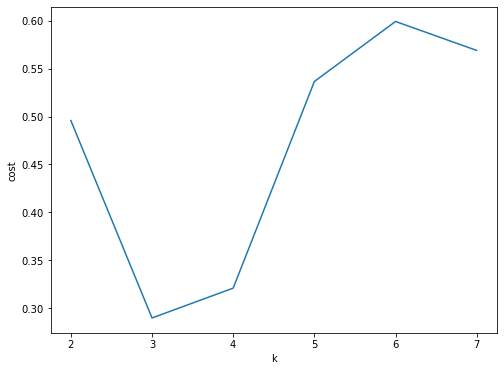

In [53]:
predictions = reg_kmeans(small_sample, 2, 8)

In [54]:
labels_clusters = predictions[2].select(['label', 'prediction'])

Total data: 633475 - Data in K0: 25534
Cluster data assigned to K0 as % of total data: 4.030782588105293%
benign : 25391
udpplain : 34
scan : 33
syn : 22
ack : 30
udp : 24



Total data: 633475 - Data in K1: 122623
Cluster data assigned to K1 as % of total data: 19.357196416591027%
benign : 73
udpplain : 30398
ack : 30269
udp : 61883



Total data: 633475 - Data in K2: 188507
Cluster data assigned to K2 as % of total data: 29.757606851099094%
benign : 97
udpplain : 82
ack : 66100
udp : 122228



Total data: 633475 - Data in K3: 4793
Cluster data assigned to K3 as % of total data: 0.7566202296854652%
benign : 4793



Total data: 633475 - Data in K4: 47407
Cluster data assigned to K4 as % of total data: 7.483641816961996%
benign : 2
udpplain : 47405



Total data: 633475 - Data in K5: 244611
Cluster data assigned to K5 as % of total data: 38.614152097557124%
benign : 52632
udpplain : 3
scan : 80862
syn : 110397
ack : 712
udp : 5





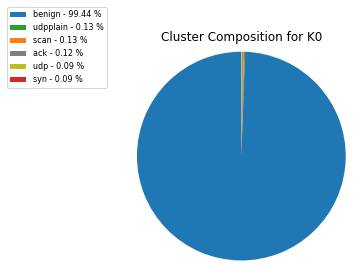

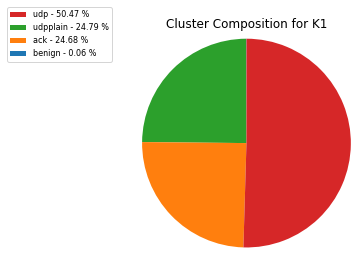

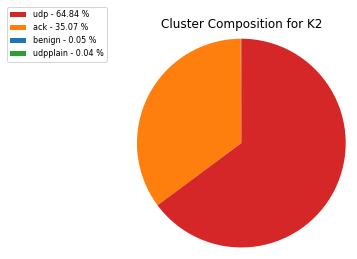

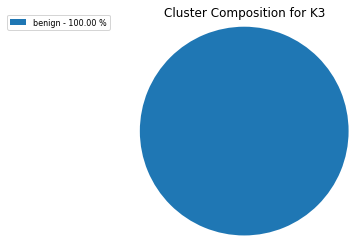

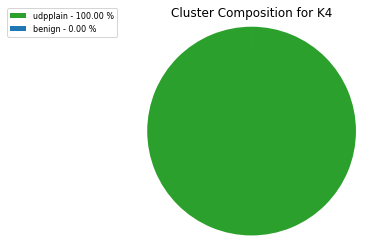

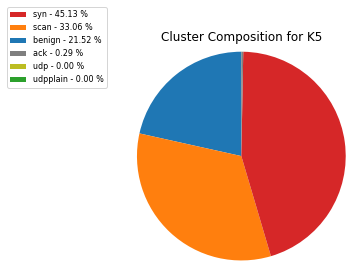

In [55]:
for i in range(predictions[1]):
    cluster = labels_clusters.filter(
        labels_clusters['prediction'] == i).groupBy('label').count().collect()
    assigned = sum([l[1] for l in cluster])
    total = small_sample.count()
    print(f'Total data: {total} - Data in K{i}: {assigned}')
    print(
        f'Cluster data assigned to K{i} as % of total data: {(assigned/total)*100}%')
    for x in cluster:
        print(f'{x[0]} : {x[1]}')
    pie(cluster, i)
    print('\n\n')